In [10]:
#импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import time
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as st
from faker import Faker

In [46]:
duplicates = test_data.sample(frac=0.1, replace=True)
test_data = pd.concat([test_data, duplicates], ignore_index=True)

In [41]:
#удалить пустые / na строки
#удалить дубли
#строки в которых нет цифр превратить в пустые
def remove_d(df):
    df.drop_duplicates(ignore_index=True, inplace=True)
    return df

def remove_empty(df):
    df.dropna()
    return df
    


#создаем новый датафрейм на основе основного, с средней, медианой и количеством уникальных значений на каждый час
def agg_df(df):
    short_d_ag = pd.DataFrame({
                           'h_mean': df.groupby(df['date'].dt.floor('h'))['numb'].mean().round(2),
                           'h_median': df.groupby(df['date'].dt.floor('h'))['numb'].median().round(2),
                           'unic': df.groupby(df['date'].dt.floor('h'))['name'].nunique()})
    
    return short_d_ag

#SQL запрос для агрегации данных, сгруппированных на каждый час
#SELECT date_trunc('hour', date) date
#       avg(numb) h_mean,
#       median(numb) h_median,
#       count(distinct name) unic
#FROM test_data
#group by date_trunc('hour', date)

#merge соединяем основной датафрейм и датафрейм с агрегированными данными
def merge_df(df1, df2):
    df1['hours'] = df1['date'].dt.floor('h')
    full_short_d = pd.merge(df1, df2, left_on = 'hours', right_on = 'date')
    return full_short_d

#Строим гистограмму для колонки чисел с плавающей точкой
def hist(df):
    plt.hist(df['numb'],color = 'blue', edgecolor = 'black')
    plt.title('Гистограмма')

#Строим график средней величины по месяцам для колонки с числами
def pl_avg_numb(df):
    
    vis = pd.DataFrame(df.groupby(df['date'].dt.to_period(freq='M').dt.to_timestamp())['numb'].mean())
    line = sns.lineplot(data=vis, x='date', y='numb')
    line.set_title('Среднее значение numeric по месяцам')
    line.set_xlabel(None)
    line.set_ylabel(None)


#Строим тепловую карту для частотности символом в колонке с именами,
#для этого ощищаем имена от пробелом и других ненужных символов,
#агрегируем по месяцам
def heatmap(df):


    df_grouped = df.groupby(df['date'].dt.to_period(freq='M').dt.to_timestamp())['name'].apply(' '.join).reset_index()
    df_grouped['name'] = [''.join(filter(str.isalpha, string.lower())) for string in df_grouped['name']]

    df_grouped = pd.concat([df_grouped, df_grouped['name'].apply(lambda x: pd.Series({c: x.count(c) for c in set(x)}))], axis=1)
    df_grouped = df_grouped.drop(columns=['name'])
    df_grouped['date'] = pd.to_datetime(df_grouped['date']).dt.to_period('M')
    df_grouped.set_index('date', inplace=True) 
    plt.figure(figsize=(10, 6))
    heatmap = sns.heatmap(df_grouped, cbar_kws= {'orientation': 'horizontal'} )
    heatmap.set_title('Тепловая карта по датам и частоте символов')
    heatmap.set_ylabel(None)


In [45]:
# Генерация имен
fake = Faker()
names = [fake.name() for _ in range(50000)]


# Генерация случайных чисел с плавающей точкой

random_floats = np.random.uniform(0, 287557.9, 10000)

#Задаем начальную и конечную дату для генерации временных меток
start_d = datetime(2020, 1, 1)
end_d = datetime(2021, 1, 1)

# Генерация случайных дат
dat = np.random.randint(start_d.timestamp(), end_d.timestamp(), 1000000)

#Генерируем итоговый датасет
test_data = pd.DataFrame({'date':[datetime.fromtimestamp(date) for date in dat],
                        'numb':[random.choice(random_floats) for _ in range(1000000)],
                        'name':[random.choice(names) for _ in range(1000000)]})
#Сортируем данные по дате и переопределяем индекс
test_data.sort_values('date').reset_index(drop=True)

,date,numb,name
0,2020-01-01 00:00:30,106736.891863,Veronica Williams
1,2020-01-01 00:02:01,133929.192554,Sabrina Atkins
2,2020-01-01 00:02:32,233692.146624,Mark Taylor
3,2020-01-01 00:03:25,191192.816671,Jonathan Wright
4,2020-01-01 00:04:31,207853.260389,Stacy Phillips
...,...,...,...
999995,2020-12-31 23:57:34,78590.015713,Matthew Aguirre
999996,2020-12-31 23:57:42,253069.750257,Summer Meyer
999997,2020-12-31 23:58:04,79267.628003,Patrick Macdonald
999998,2020-12-31 23:58:24,154799.232817,Joshua Coleman


Очищаем данные от пропуска значений и удаляем дубликаты

In [47]:

test_data = remove_d(test_data)
test_data = remove_empty(test_data)
print(test_data)

                      date           numb              name
0      2020-09-20 04:34:23  225612.767380  William Gonzalez
1      2020-09-16 01:00:01  114079.734788   Rebecca Winters
2      2020-04-27 18:43:30  124218.673308      Robert House
3      2020-09-17 12:29:48   33924.583357        Toni Clark
4      2020-10-29 04:16:03  175629.498863      Jamie Hansen
...                    ...            ...               ...
999995 2020-02-01 22:22:15    5020.585035       Logan Avila
999996 2020-02-14 12:29:43  168376.376929  Christopher Hall
999997 2020-11-17 23:12:04   76908.946476     Stephen Lynch
999998 2020-03-16 06:29:48   79112.551418    Vanessa Gibson
999999 2020-01-19 14:32:15  200159.749314   Anthony Camacho

[1000000 rows x 3 columns]


Агрегируем данные на каждый час и соединяем данные с основной таблицей

In [48]:
test_data = merge_df(test_data, agg_df(test_data))
test_data.drop('hours', axis=1, inplace=True)
print(test_data)

                      date           numb              name     h_mean  \
0      2020-09-20 04:34:23  225612.767380  William Gonzalez  143401.55   
1      2020-09-16 01:00:01  114079.734788   Rebecca Winters  153196.96   
2      2020-04-27 18:43:30  124218.673308      Robert House  142881.81   
3      2020-09-17 12:29:48   33924.583357        Toni Clark  135112.67   
4      2020-10-29 04:16:03  175629.498863      Jamie Hansen  128374.49   
...                    ...            ...               ...        ...   
999995 2020-02-01 22:22:15    5020.585035       Logan Avila  146616.23   
999996 2020-02-14 12:29:43  168376.376929  Christopher Hall  153243.72   
999997 2020-11-17 23:12:04   76908.946476     Stephen Lynch  141557.26   
999998 2020-03-16 06:29:48   79112.551418    Vanessa Gibson  148971.66   
999999 2020-01-19 14:32:15  200159.749314   Anthony Camacho  167636.82   

         h_median  unic  
0       145834.06   110  
1       163443.44   123  
2       158218.86   108  
3      

Строим гистограмму по значениям в колонке с числами

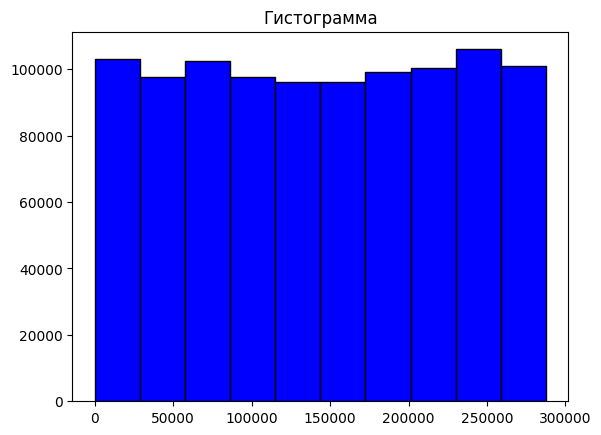

In [51]:
hist(test_data)

График показывающий среднее значение в колонке с числом по месяцам

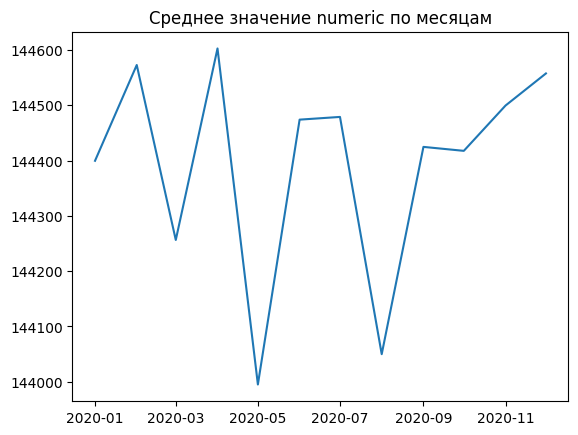

In [52]:
pl_avg_numb(test_data)

Тепловая карта для частотности символов сгруппированная по месяцам

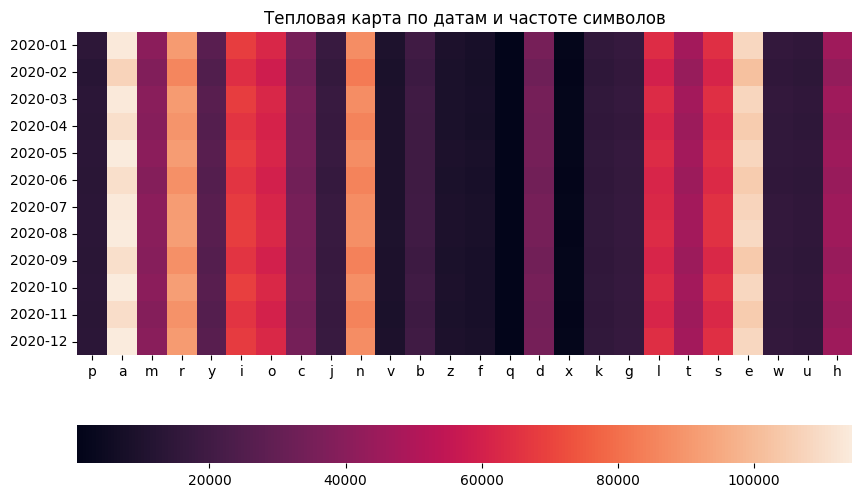

In [53]:
heatmap(test_data)